In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [5]:
class PopulationEvolution:
    def __init__(self, population_size = 100, top_k = 20, main_genotype_length = 1, meta_level_1 = 3, meta_level_2 = 3, meta_initialization = 0.1, meta_mutation_rate_1 = 0.1, meta_mutation_rate_2 = 0.1, nr_of_generations = 2000, referential = False, elitism = True, regularization = False, regularizer = 0.01, value = 1, mutation_type = 2):        
        """
        Initialize the parameters.

        Parameters:
        -----------
        population_size : int, default=100
            The size of the population, equal for both populations. Must be >=1.
        
        top_k : int, default=20
            The number of top individuals selected for reproduction, equal for both populations. Must be >= 1 and <= population_size.

        main_genotype_length : int, default=1
            The length of the main part of the genotype (the part of the genome that does not contain meta-parameters), i.e., the part representing the solution.

        meta_level_1 : int, default=3
            The number of metaparameters for the individuals from the first population. Must be >= 0.

        meta_level_2 : int, default=3
            The number of metaparameters for the individuals from the second population. Must be >= 0.

        meta_initialization : float, default=0.1
            Initialization value for the metaparameters. (All metaparameters are initialized to the same value.) Must be > 0.

        meta_mutation_rate_1 : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate for the individuals from the first population. In that case, it is used only if self-referential mutations rates are inactive (referential == False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu et al., 2023.

        meta_mutation_rate_2 : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate for the individuals from the second population. In that case, it is used only if self-referential mutations rates are inactive (referential == False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu at al., 2023.

        nr_of_generations : int, default=2000
            The number of generations for the algorithm to run.

        referential : bool, default=False
            Whether or not to use the self-referential top meta-mutation rate. Applies equally to both populations.

        elitism : bool, default=True
            If True, retains a certain number of top-performing individuals in each generation.

        regularization : bool, default=False
            If True, applies regularization to prevent reaching pure strategy Nash equilibria.

        regularizer : float, default=0.01
            The regularization factor applied when regularization is enabled.

        value : float, default=0.5
            The value of the auctioned item, identical for both populations/players. Should be positive.

        mutation_type: int, default=1
            The type of meta-mutation scheme used - regular (1) or additive (2).

        Raises:
        -------
        ValueError:
            If any of the input parameters do not meet the constraints mentioned above.

        """
        if population_size < 1:
            raise ValueError("Invalid population size, should be >=1")
        if (top_k < 1) or (top_k > population_size):
            raise ValueError("Invalid number of elites, should be >=1 and <= population size")
        if main_genotype_length < 1:
            raise ValueError("Invalid length of the main genotype, should be >=1")
        if meta_level_1 < 0:
            raise ValueError("Invalid number of metaparameters for the first population, should be >=0") 
        if meta_level_2 < 0:
            raise ValueError("Invalid number of metaparameters for the second population, should be >=0") 
        if meta_level_2 <= 0:
            raise ValueError("Invalid number of metaparameters for the second population, should be >=0") 
        if meta_mutation_rate_1 <= 0:
            raise ValueError("Invalid meta_mutation_rate_1 parameter, should be > 0 since it is used as a scale/std") 
        if meta_mutation_rate_2 <= 0:
            raise ValueError("Invalid meta_mutation_rate_2 parameter, should be > 0 since it is used as a scale/std") 
        if meta_initialization <= 0:
            raise ValueError("Invalid value for the meta_initialization parameter, should be > 0 since it is used as a scale/std")
        if value <= 0:
            raise ValueError("Invalid value for the value of the auctioneed item, should be > 0")      
        if mutation_type not in [1,2]:
            raise ValueError("Invalid value for the mutation_type parameter, should be equal to 1 (regular meta-mutation rates) or 2 (additive meta-mutation rates)")          
        self.population_size = population_size
        self.top_k = top_k
        self.main_genotype_length = main_genotype_length
        self.meta_level_1 = meta_level_1
        self.meta_level_2 = meta_level_2
        self.meta_initialization = meta_initialization
        self.meta_mutation_rate_1 = meta_mutation_rate_1
        self.meta_mutation_rate_2 = meta_mutation_rate_2
        self.nr_of_generations = nr_of_generations
        self.referential = referential
        self.elitism = elitism
        self.regularization = regularization
        self.regularizer = regularizer
        self.value = value
        self.mutation_type = mutation_type
        self.t = 0 # time/current generation
        self.population1 = self.initialize_population(self.meta_level_1)
        self.population2 = self.initialize_population(self.meta_level_2)

    def penalty(self, solution):
        raise NotImplementedError("This function is under construction.")

    def initialize_population(self, metalevel):
        e1 = np.random.normal(0,self.meta_initialization,(self.main_genotype_length+metalevel,self.population_size)).T
        return e1

    def play(self, solution): 
        return abs(solution[0])
            
    def match(self, solution1, solution2, value):
        '''
        Play a match. Returns tuple (payoff 1, payoff2, action1, action2)
        '''
        a1 = self.play(solution1)
        a2 = self.play(solution2)
        if a1 > a2:
            return value-a1, -a2, a1, a2
        elif a1 == a2:
            return value/2-a1, value/2-a2, a1, a2
        else:
            return -a1, value-a2, a1, a2

    def mutate(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(0, abs(solution[-1]))
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(new_solution[i+1]))
                else:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(new_solution[self.main_genotype_length]))
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate)
            else:
                raise RuntimeError("Self-referentiality without meta-parameters.")
        return new_solution
    
    def mutate_additive(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(solution[-1], mrate)
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(new_solution[i+1], mrate)
                else:
                    new_solution[i] = solution[i]+np.random.normal(new_solution[self.main_genotype_length],mrate)
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate)
            else:
                raise RuntimeError("Self-referentiality without meta-parameters.")
        return new_solution

    def evolve(self):
        mean_scores1, mean_scores2  = [], [] # mean scores
        mean_as1, mean_as2 = [], [] # mean actions
        mean_meta1_1s, mean_meta1_2s = [], [] #meta lowest meta-parameters
        for t in range(0, self.nr_of_generations+1):
            self.t = t
            if self.t % 100 == 0:
                print('Generation: {}'.format(t))
            scores1, scores2 = np.zeros((2,self.population_size))
            if self.regularization:
                regscores1, regscores2 = np.zeros((2,self.population_size))
            as1, as2 = np.zeros((2,self.population_size))
            # Evaluate all pairs head-to-head
            for i, solution1 in enumerate(self.population1):
                for j, solution2 in enumerate(self.population2):
                    score1, score2, p1, p2 = self.match(solution1, solution2, self.value)
                    scores1[i] += score1
                    scores2[j] += score2
                    as1[i] += p1 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
                    as2[j] += p2 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
                    if self.regularization:
                        regscores1[i] += score1+self.penalty(solution1)
                        regscores2[j] += score2+self.penalty(solution2)
            scores1 /= self.population_size # Divisions by the number of games played by each individual
            scores2 /= self.population_size
            as1 /= self.population_size
            as2 /= self.population_size
            mean_scores1.append(np.mean(scores1))
            mean_scores2.append(np.mean(scores2))
            mean_as1.append(np.mean(as1))
            mean_as2.append(np.mean(as2))
            try:
                mean_meta1_1s.append(np.mean(self.population1[:,1]))
            except:
                mean_meta1_1s.append(0)
            try:
                mean_meta1_2s.append(np.mean(self.population2[:,1]))
            except:
                mean_meta1_2s.append(0)
            finalscores1 = regscores1 if self.regularization else scores1
            finalscores2 = regscores2 if self.regularization else scores2
            top_indices1 = np.argsort(finalscores1)[-self.top_k:]
            top_indices2 = np.argsort(finalscores2)[-self.top_k:]
            # Building the new populations
            new_population1 = []
            new_population2 = []
            if self.elitism == True:
                for i in top_indices1:
                    new_population1.append(self.population1[i])
                for j in top_indices2:
                    new_population2.append(self.population2[j])
            while len(new_population1) < self.population_size:
                parent = copy.deepcopy(self.population1[np.random.choice(top_indices1)])
                if self.mutation_type == 1:
                    new_population1.append(self.mutate(parent, self.meta_mutation_rate_1))
                else:
                    new_population1.append(self.mutate_additive(parent, self.meta_mutation_rate_1))
            while len(new_population2) < self.population_size:
                parent = copy.deepcopy(self.population2[np.random.choice(top_indices2)])
                if self.mutation_type == 1:
                    new_population2.append(self.mutate(parent, self.meta_mutation_rate_2))
                else:
                    new_population2.append(self.mutate_additive(parent, self.meta_mutation_rate_2))
            self.population1 = np.array(new_population1)
            self.population2 = np.array(new_population2)
        return mean_scores1, mean_scores2, mean_as1, mean_as2, mean_meta1_1s, mean_meta1_2s

In [18]:
popevo = PopulationEvolution(population_size = 256, top_k = 128, main_genotype_length = 1, meta_level_1 = 2, meta_level_2 = 1, meta_initialization = 0.1, meta_mutation_rate_1 = 0.05, meta_mutation_rate_2 = 0.05, nr_of_generations = 2000, referential = False, elitism = True, regularization = False, regularizer = 2, value = 1, mutation_type = 2)
mean_scores1, mean_scores2, mean_as1, mean_as2, mean_meta1_1s, mean_meta1_2s = popevo.evolve() #top k = 5 bitno, dodati regularizaciju

Generation: 0
Generation: 100
Generation: 200
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
Generation: 800
Generation: 900
Generation: 1000
Generation: 1100
Generation: 1200
Generation: 1300
Generation: 1400
Generation: 1500
Generation: 1600
Generation: 1700
Generation: 1800
Generation: 1900


Mean score, 1st population:  0.01662369487190257
Mean score, 2nd population:  -0.14486639300026682


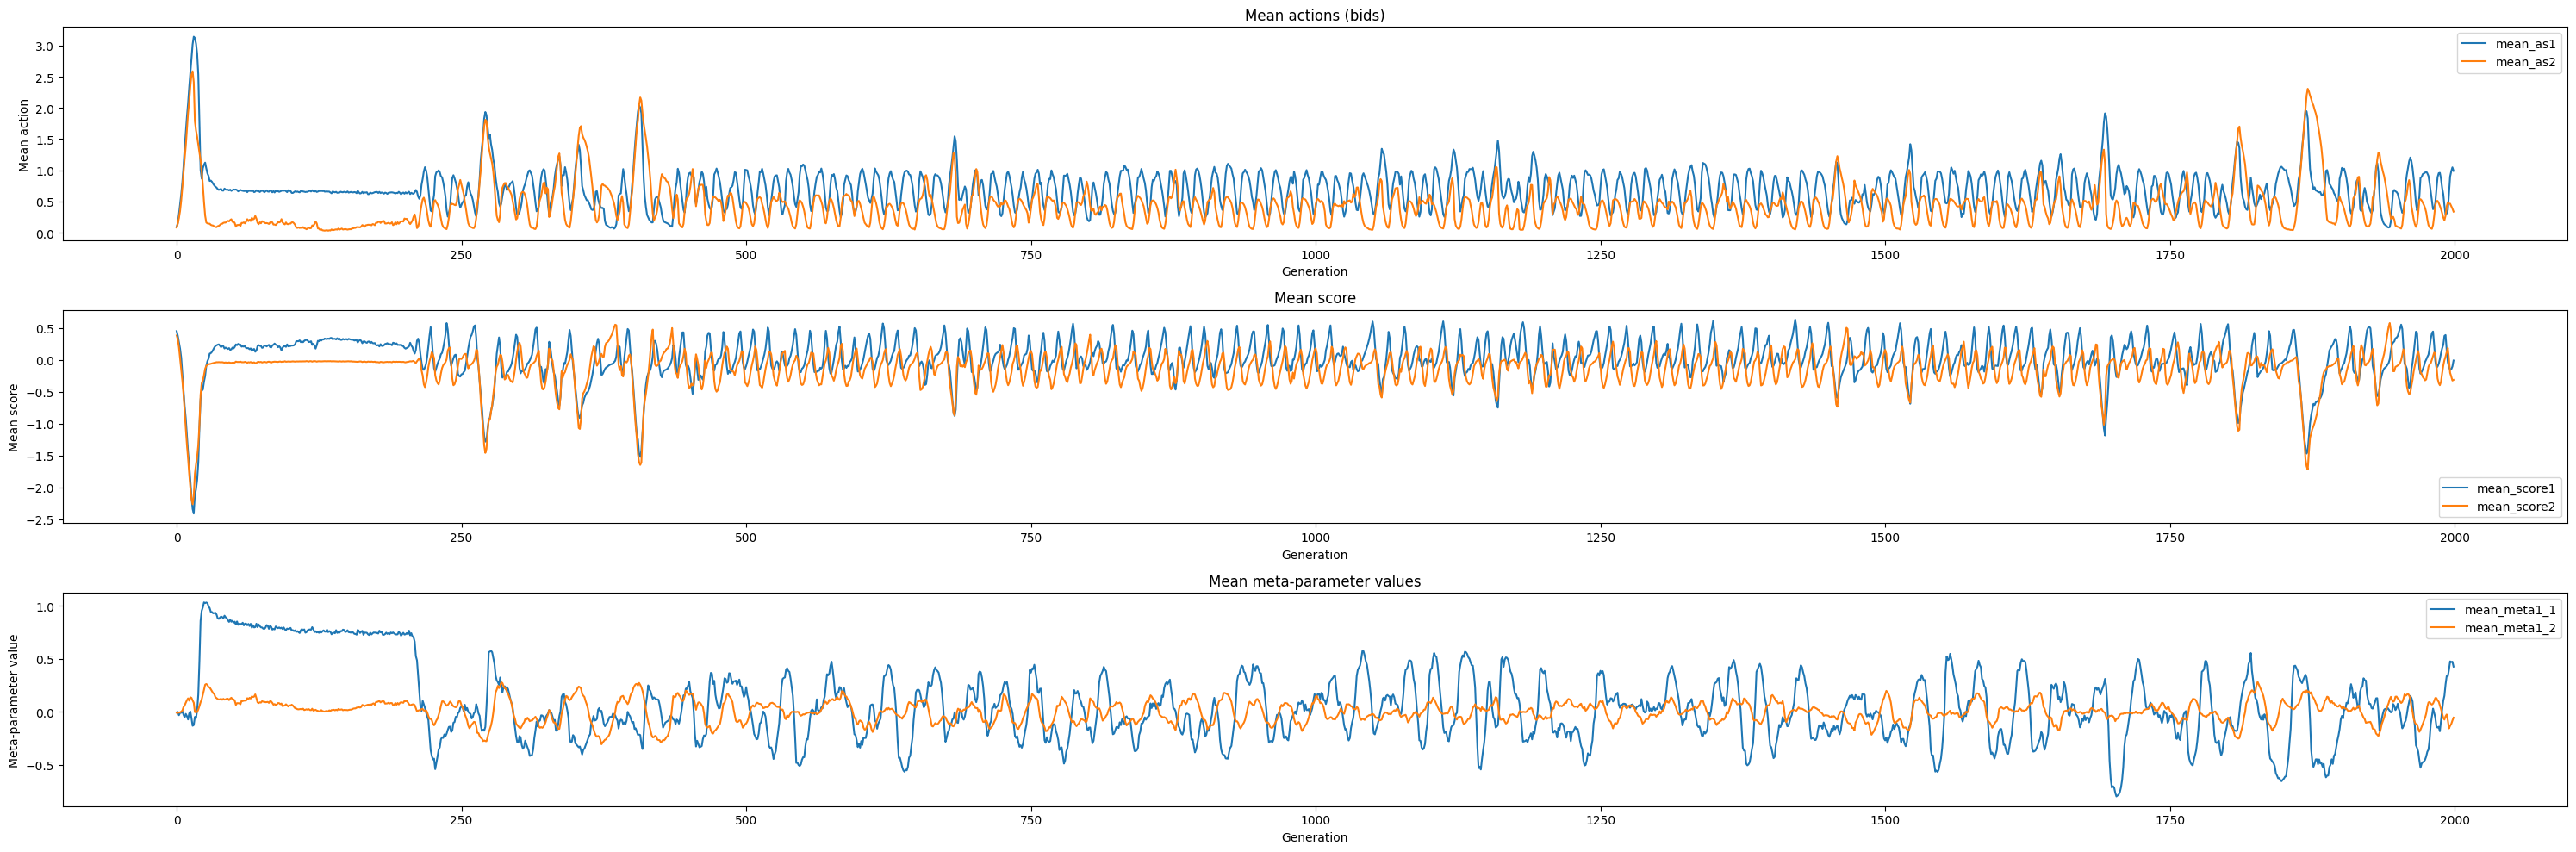

In [26]:
def plotter(final_t):
    plt.figure(figsize=(30, 10))
    plt.subplot(3, 1, 1)
    plt.plot(mean_as1[0:final_t])
    plt.plot(mean_as2[0:final_t])
    plt.title("Mean actions (bids)")
    plt.xlabel("Generation")
    plt.ylabel("Mean action")
    plt.legend(["mean_as1","mean_as2"])
    plt.subplot(3, 1, 2)
    plt.plot(mean_scores1[0:final_t])
    plt.plot(mean_scores2[0:final_t])
    plt.title("Mean score")
    plt.xlabel("Generation")
    plt.ylabel("Mean score")
    plt.legend(["mean_score1","mean_score2"])
    plt.subplot(3, 1, 3)
    plt.plot(mean_meta1_1s[0:final_t])
    plt.plot(mean_meta1_2s[0:final_t])
    plt.title("Mean meta-parameter values")
    plt.xlabel("Generation")
    plt.ylabel("Meta-parameter value")
    plt.tight_layout()  
    plt.legend(["mean_meta1_1","mean_meta1_2"])    
    print("Mean score, 1st population: ", np.mean(mean_scores1))
    print("Mean score, 2nd population: ", np.mean(mean_scores2))
plotter(2000)